# Tumor Classification
## VGG19 is going to be used for tumor classification
### Training

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import all necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random
import tensorflow as tf
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from torchvision.models import vgg19, resnet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

In [ ]:
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # VGG excepts 224x224 images
    transforms.ToTensor(), # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize with ImageNet stats
])
dataset = datasets.ImageFolder(root="/content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/datasets/preprocessed_data/lung-cancer-detection/", transform=data_transforms)
train_size = int(0.8*len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)

In [ ]:
import torch.nn as nn
from torchvision.models import vgg19

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = vgg19(pretrained=True) # Load pre-trained VGG19 model
for param in model.features.parameters():
    param.requires_grad = False # Freeze the feature extractor layers

model.classifier[6] = nn.Linear(4096, 3) #3 Classes
model = model.to(device) # Move model to device

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 77.9MB/s]


In [ ]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss() # Loss function
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 10
vgg_train_losses = []
vgg_train_accuracies = []
vgg_val_losses = []
vgg_val_accuracies = []

best_val_loss = float('inf')

save_path = '/content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/saved_models/best_vgg_model.pth'

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        __, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total
    vgg_train_losses.append(epoch_loss)
    vgg_train_accuracies.append(epoch_accuracy)

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            __, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

        current_val_loss = val_loss / len(val_loader)
        vgg_val_losses.append(val_loss / len(val_loader))
        vgg_val_accuracies.append(val_correct / val_total)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}, Val Loss: {vgg_val_losses[-1]:.4f}, Val Accuracy: {vgg_val_accuracies[-1]:.4f}")
    if current_val_loss < best_val_loss:
        best_val_loss = current_val_loss
        torch.save(model.state_dict(), save_path)
        print("Model saved")

Epoch [1/10], Train Loss: 0.5230, Train Accuracy: 0.7493, Val Loss: 0.2433, Val Accuracy: 0.9139
Model saved
Epoch [2/10], Train Loss: 0.2083, Train Accuracy: 0.9153, Val Loss: 0.1276, Val Accuracy: 0.9500
Model saved
Epoch [3/10], Train Loss: 0.1113, Train Accuracy: 0.9493, Val Loss: 0.2345, Val Accuracy: 0.9139
Epoch [4/10], Train Loss: 0.0561, Train Accuracy: 0.9847, Val Loss: 0.1295, Val Accuracy: 0.9556
Epoch [5/10], Train Loss: 0.0351, Train Accuracy: 0.9875, Val Loss: 0.0683, Val Accuracy: 0.9639
Model saved
Epoch [6/10], Train Loss: 0.0571, Train Accuracy: 0.9785, Val Loss: 0.0823, Val Accuracy: 0.9667
Epoch [7/10], Train Loss: 0.0301, Train Accuracy: 0.9882, Val Loss: 0.0462, Val Accuracy: 0.9778
Model saved
Epoch [8/10], Train Loss: 0.0097, Train Accuracy: 0.9965, Val Loss: 0.0513, Val Accuracy: 0.9806
Epoch [9/10], Train Loss: 0.0194, Train Accuracy: 0.9951, Val Loss: 0.0617, Val Accuracy: 0.9778
Epoch [10/10], Train Loss: 0.0064, Train Accuracy: 0.9986, Val Loss: 0.0514, Va

### Evaluation

VGG19 Evaluation Metrics:
accuracy: 0.9917
precision: 0.9917
recall: 0.9917
f1: 0.9917


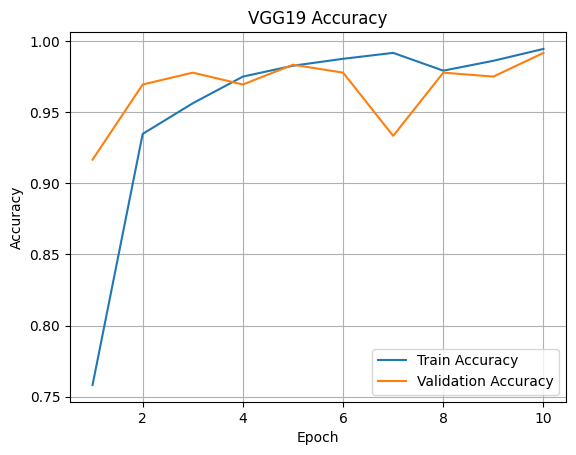

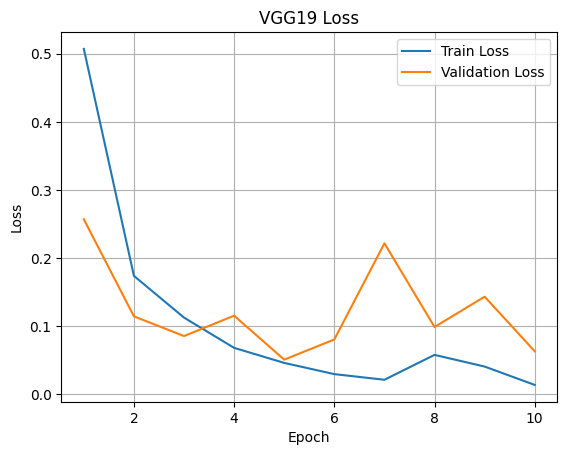

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

model.eval()
all_preds = []
all_labels = []
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

y_true = np.array(all_labels)
y_pred = np.array(all_preds)

sklearn_accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

vgg_metrics = {
    "accuracy": round(sklearn_accuracy, 4),
    "precision": round(precision, 4),
    "recall": round(recall, 4),
    "f1": round(f1, 4)
}
print("VGG19 Evaluation Metrics:")
for key, value in vgg_metrics.items():
    print(f"{key}: {value}")

# ACCURACY
plt.plot(range(1, num_epochs+1), vgg_train_accuracies, label="Train Accuracy")
plt.plot(range(1, num_epochs+1), vgg_val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("VGG19 Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# LOSS
plt.plot(range(1, num_epochs+1), vgg_train_losses, label="Train Loss")
plt.plot(range(1, num_epochs+1), vgg_val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("VGG19 Loss")
plt.legend()
plt.grid(True)
plt.show()

## ResNet 50 Training

In [ ]:
from torchvision.models import resnet50
resnet50 = resnet50()
num_features = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_features, 3) # 3 Classes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50 = resnet50.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.parameters(), lr=0.0001)

epochs = 10
rn_train_losses = []
rn_train_accuracies = []
rn_val_losses = []
rn_val_accuracies = []

for epoch in range(epochs):
    resnet50.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct/total
    rn_train_losses.append(epoch_loss)
    rn_train_accuracies.append(epoch_accuracy)

    resnet50.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = resnet50(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

        rn_val_losses.append(val_loss/len(val_loader))
        rn_val_accuracies.append(val_correct/val_total)

        print(f"Epoch {epoch+1}/10, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_accuracy:.4f}, Val Loss:{rn_val_losses[-1]:.4f}, Val Acc: {rn_val_accuracies[-1]:.4f}")

Epoch 1/10, Train Loss: 0.9100, Train Acc: 0.5625, Val Loss:1.3467, Val Acc: 0.4278
Epoch 2/10, Train Loss: 0.6138, Train Acc: 0.7354, Val Loss:0.9821, Val Acc: 0.6000
Epoch 3/10, Train Loss: 0.4456, Train Acc: 0.8410, Val Loss:1.9319, Val Acc: 0.6167
Epoch 4/10, Train Loss: 0.3162, Train Acc: 0.8896, Val Loss:0.2622, Val Acc: 0.9000
Epoch 5/10, Train Loss: 0.2249, Train Acc: 0.9174, Val Loss:2.8523, Val Acc: 0.6500
Epoch 6/10, Train Loss: 0.2340, Train Acc: 0.9146, Val Loss:0.2108, Val Acc: 0.9333
Epoch 7/10, Train Loss: 0.1025, Train Acc: 0.9674, Val Loss:1.2090, Val Acc: 0.7056
Epoch 8/10, Train Loss: 0.0672, Train Acc: 0.9757, Val Loss:0.5703, Val Acc: 0.8417
Epoch 9/10, Train Loss: 0.0992, Train Acc: 0.9660, Val Loss:0.7302, Val Acc: 0.7611
Epoch 10/10, Train Loss: 0.0772, Train Acc: 0.9757, Val Loss:0.6923, Val Acc: 0.8167


ResNet50 Evaluation metrics: 
accuracy:0.82
precision:0.8494
recall:0.8167
f1:0.802


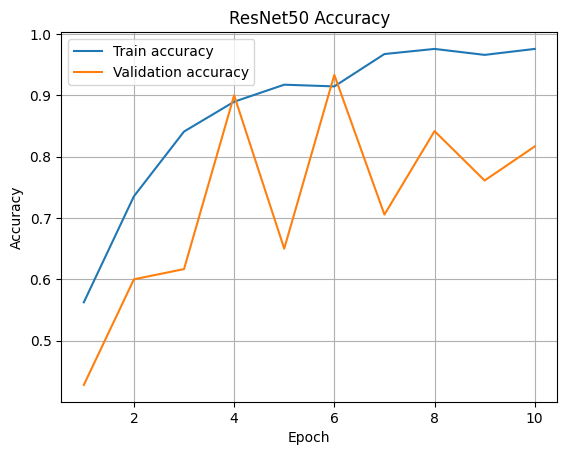

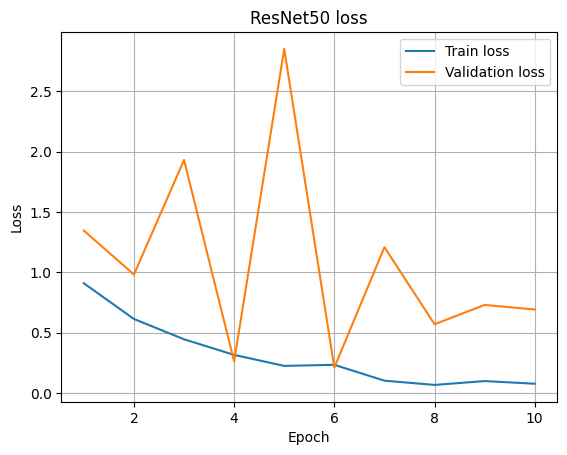

In [ ]:
epochs = 10

resnet50.eval()
all_preds = []
all_labels = []
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet50(images)
        _, preds = torch.max(outputs, 1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

y_true = np.array(all_labels)
y_pred = np.array(all_preds)

resnet_metrics = {
    "accuracy":round(correct / total, 2),
    "precision":round(precision_score(y_true, y_pred, average="weighted"), 4),
    "recall":round(recall_score(y_true, y_pred, average="weighted"),4),
    "f1":round(f1_score(y_true, y_pred, average="weighted"), 4)
}
print("ResNet50 Evaluation metrics: ")
for key, value in resnet_metrics.items():
    if key != "Model":
        print(f"{key}:{value}")

plt.plot(range(1, epochs+1), rn_train_accuracies, label="Train accuracy")
plt.plot(range(1, epochs+1), rn_val_accuracies, label="Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("ResNet50 Accuracy")
plt.legend()
plt.grid(True)
plt.show()

plt.plot(range(1, epochs+1), rn_train_losses, label="Train loss")
plt.plot(range(1, epochs+1), rn_val_losses, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("ResNet50 loss")
plt.legend()
plt.grid(True)
plt.show()

## MobileNet v3

Found 1440 images belonging to 3 classes.
Found 360 images belonging to 3 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 30s 408ms/step - accuracy: 0.3583 - loss: 1.3996 - val_accuracy: 0.5500 - val_loss: 0.9044
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 13s 300ms/step - accuracy: 0.4805 - loss: 1.0836 - val_accuracy: 0.5972 - val_loss: 0.8163
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 251ms/step - accuracy: 0.5566 - loss: 0.9597 - val_accuracy: 0.6278 - val_loss: 0.7553
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 238ms/step - accuracy: 0.5641 - loss: 0.8778 - val_accuracy: 0.7000 - val_loss: 0.7003
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 249ms/step - accuracy: 0.6096 - loss: 0.8294 - val_accuracy: 0.7250 - val_loss: 0.6629
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 269ms/step - accuracy: 0.6449 - loss: 0.7523 - val_accuracy: 0.7528 - val_loss: 0.6319
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 252ms/step - accuracy: 0.6503 - loss: 0.7263 - val_accuracy: 0.7639 - val_loss: 0.6125
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 268ms/step - accuracy: 0.6582 - loss: 0.7030 - val_accu

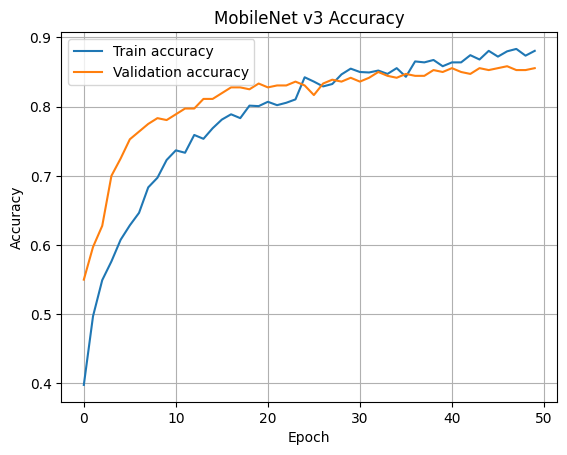

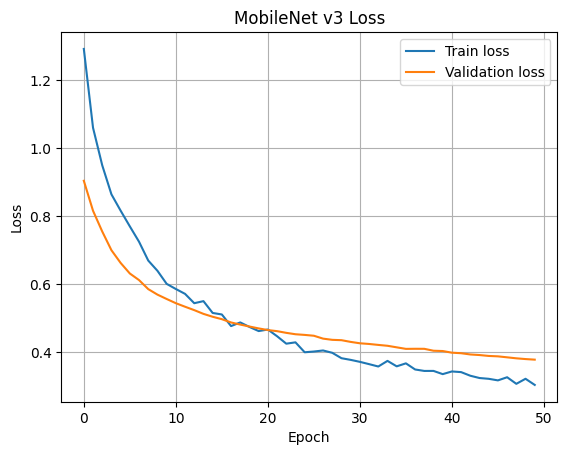

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt

data_dir = "/content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/datasets/preprocessed_data/lung-cancer-detection/"
img_size = (224, 224)
batch_size = 32
epochs = 50

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="training",
    shuffle=True
)
val_gen = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(3, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
history = model.fit(train_generator, validation_data=val_gen, epochs=epochs)
y_pred_probs = model.predict(val_gen)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = val_gen.classes

mobilenet_metrics = {
    "accuracy":round(accuracy_score(y_true, y_pred), 4),
    "precision":round(precision_score(y_true, y_pred, average="weighted"),4),
    "recall":round(recall_score(y_true, y_pred, average="weighted"),4),
    "f1":round(f1_score(y_true, y_pred, average="weighted"),4)
}

print("MobileNet v2 Evaluation metrics: ")
for key, value in mobilenet_metrics.items():
    print(f"{key}:{value}")

plt.plot(history.history["accuracy"], label="Train accuracy")
plt.plot(history.history["val_accuracy"], label="Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("MobileNet v3 Accuracy")
plt.legend()
plt.grid(True)
plt.show()

plt.plot(history.history["loss"], label="Train loss")
plt.plot(history.history["val_loss"], label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("MobileNet v3 Loss")
plt.legend()
plt.grid(True)
plt.show()

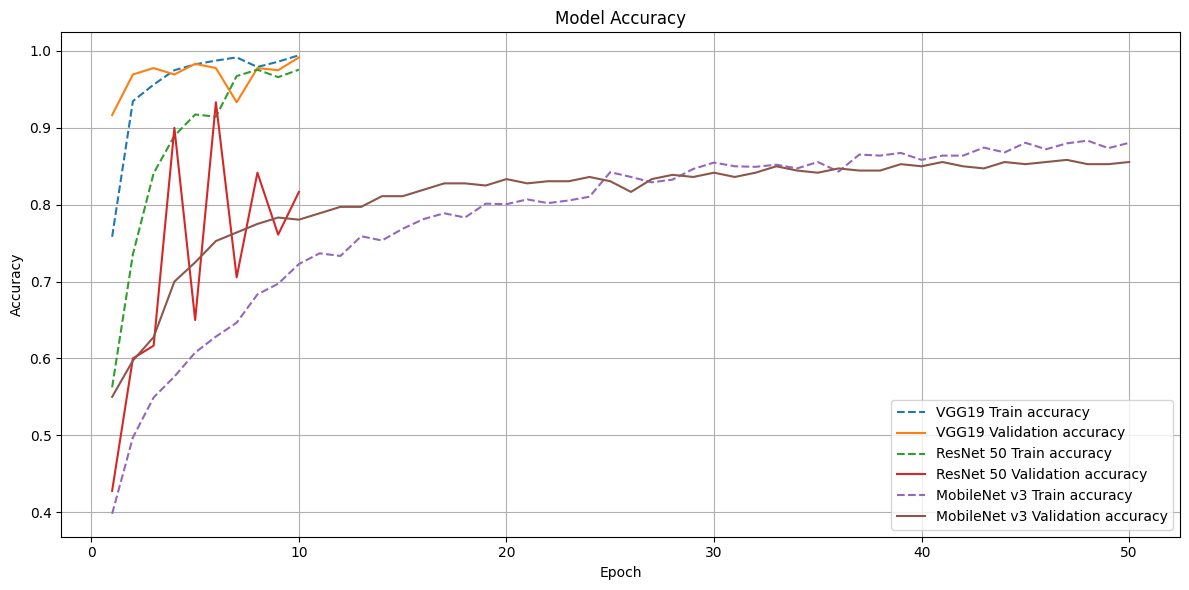

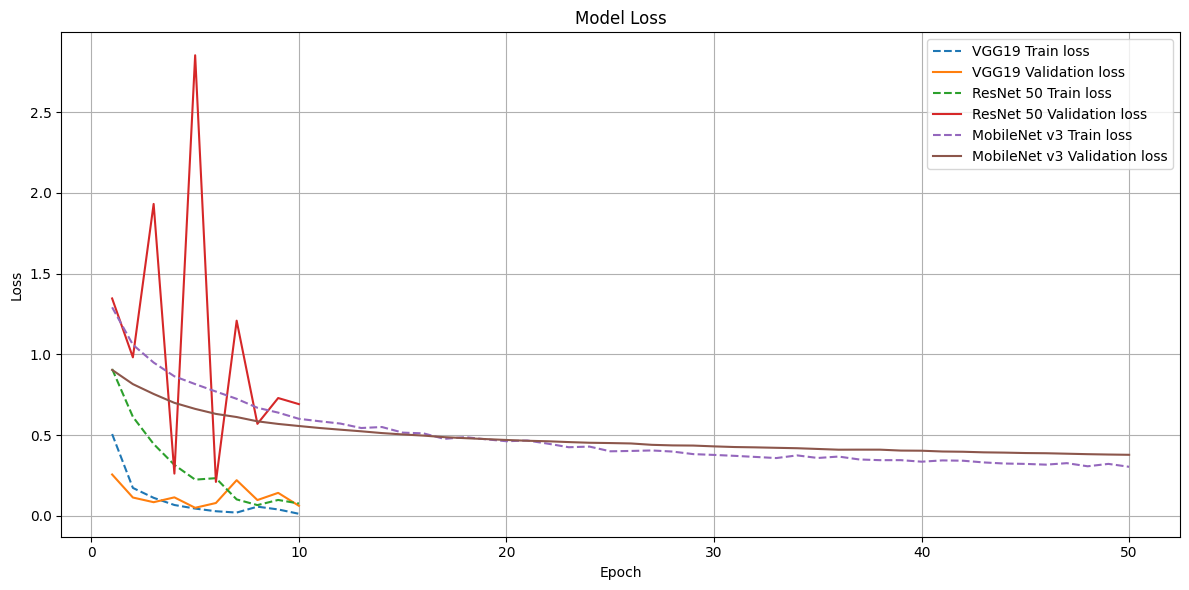

In [ ]:
# Epoch ranges for comparison of models
vgg_epochs = range(1,11)
resnet_epochs = range(1,11)
mobilenet_epochs = range(1, len(history.history["accuracy"])+1)

# ACCURACY
plt.figure(figsize=(12,6))
plt.plot(vgg_epochs, vgg_train_accuracies, "--", label="VGG19 Train accuracy")
plt.plot(vgg_epochs, vgg_val_accuracies, label="VGG19 Validation accuracy")
plt.plot(resnet_epochs, rn_train_accuracies, "--", label="ResNet 50 Train accuracy")
plt.plot(resnet_epochs, rn_val_accuracies, label="ResNet 50 Validation accuracy")
plt.plot(mobilenet_epochs, history.history["accuracy"], "--", label="MobileNet v3 Train accuracy")
plt.plot(mobilenet_epochs, history.history["val_accuracy"], label="MobileNet v3 Validation accuracy")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# LOSS
plt.figure(figsize=(12,6))
plt.plot(vgg_epochs, vgg_train_losses, "--", label="VGG19 Train loss")
plt.plot(vgg_epochs, vgg_val_losses, label="VGG19 Validation loss")
plt.plot(resnet_epochs, rn_train_losses, "--", label="ResNet 50 Train loss")
plt.plot(resnet_epochs, rn_val_losses, label="ResNet 50 Validation loss")
plt.plot(mobilenet_epochs, history.history["loss"], "--", label="MobileNet v3 Train loss")
plt.plot(mobilenet_epochs, history.history["val_loss"], label="MobileNet v3 Validation loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Model Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

              accuracy  precision  recall      f1
Model                                            
VGG19           0.9917     0.9917  0.9917  0.9917
ResNet50        0.8200     0.8494  0.8167  0.8020
MobileNet v3    0.8556     0.8554  0.8556  0.8548


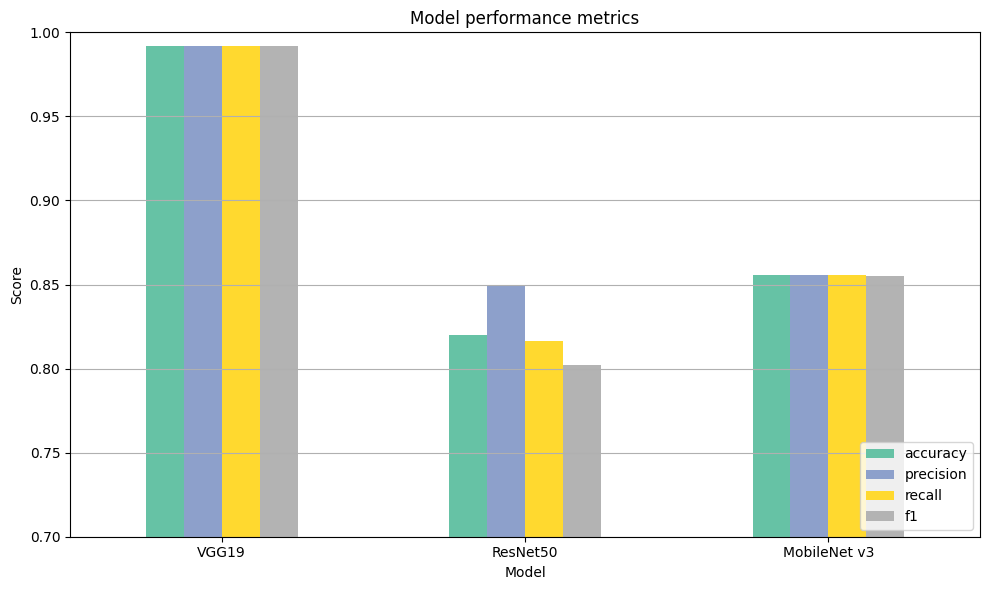

In [ ]:
import pandas as pd

all_metrics = [
    {"Model":"VGG19", **vgg_metrics},
    {"Model":"ResNet50", **resnet_metrics},
    {"Model":"MobileNet v3", **mobilenet_metrics}
]

df = pd.DataFrame(all_metrics)
df.set_index("Model", inplace=True)

print(df)

df.plot(kind="bar", figsize=(10,6), colormap="Set2")
plt.title("Model performance metrics")
plt.ylabel("Score")
plt.ylim(0.7, 1.0)
plt.grid(True, axis="y")
plt.xticks(rotation=0)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## Breast cancer detection

In [ ]:
target_count = 700
img_size=(512,512)

def get_random_transform():
  options = [
      lambda img: img.transpose(Image.FLIP_LEFT_RIGHT),
      lambda img: img.transpose(Image.FLIP_TOP_BOTTOM),
      lambda img: img.rotate(random.uniform(-30,30)),
      lambda img: img.ImageEnhance.Contrast(img).enhance(random.uniform(0.5, 1.5)),
      lambda img: img.ImageEnhance.Sharpness(img).enhance(random.uniform(1.2, 2.0)),
      lambda img: img.ImageEnhance.Color(img).enhance(random.uniform(2.0, 2.5))
  ]
  return random.choice(options)

def augment_and_save(class_name, target_count):
  class_src = os.path.join(base_dir, class_name)
  class_dest = os.path.join(output_dir, class_name)
  os.makedirs(class_dest)

  images = [f for f in os.listdir(class_src)]
  original_count = len(images)

  for img in images:
    shutil.copy(os.path.join(class_src, img), os.path.join(class_dest, img))

  extra_needed = target_count - original_count
  if extra_needed <= 0:
    return

  print(f"Need to generate {extra_needed} more images for {class_name}")

  for i in range(extra_needed):
    img_name = random.choice(images)
    try:
      with Image.open(os.path.join(class_src, img_name)) as img:
        img = img.convert("RGB").resize(img_size)
        transformed_img = get_random_transform()(img)
        save_name = f"aug_{i}_{img_name}"
        transformed_img.save(os.path.join(class_dest, save_name))
    except Exception as e:
      print(f"Error processing {img_name}: {e}")

  for class_name in class_names:
    augment_and_save(class_name, target_count)

  print(f"Augmentation complete for all classes")

In [ ]:
data_transforms=transforms.Compose([
    transforms.Resize((224,224)), #VGG excepts 224x224px
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #ImageNet mean and std
])

breast_cancer_dataset = datasets.ImageFolder(root="/content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/datasets/preprocessed_data/bc_balanced_data", transform=data_transforms)
train_size = int(0.8 * len(breast_cancer_dataset))
val_size = len(breast_cancer_dataset) - train_size

bc_train, bc_val = torch.utils.data.random_split(breast_cancer_dataset, [train_size, val_size])
bc_train_loader = DataLoader(bc_train, batch_size=32, shuffle=True)
bc_val_loader = DataLoader(bc_val, batch_size=32, shuffle=False)

In [ ]:
import torch.optim as optim

VGG19 = vgg19()

for param in VGG19.features.parameters():
  param.requires_grad = False

VGG19.classifier[6] = nn.Linear(4096, 3)
VGG19 = VGG19.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(VGG19.parameters(), lr=0.001)

num_epochs = 10
vgg_train_losses = []
vgg_train_accuracies = []
vgg_val_losses = []
vgg_val_accuracies = []

for epoch in range(num_epochs):
  VGG19.train()
  running_loss = 0.0
  correct = 0
  total = 0

  for inputs, labels in bc_train_loader:
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = VGG19(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

    _,preds = torch.max(outputs, 1)
    correct += (preds == labels).sum().item()
    total += labels.size(0)

  epoch_loss = running_loss / len(bc_train_loader)
  epoch_accuracy = correct / total
  vgg_train_losses.append(epoch_loss)
  vgg_train_accuracies.append(epoch_accuracy)

  # Evaluation
  VGG19.eval()
  val_loss = 0.0
  val_correct = 0
  val_total = 0

  with torch.no_grad():
    for inputs, labels in bc_val_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      # Permute the dimensions to match the expected format (batch_size, height, width, channels)

      outputs = VGG19(inputs)
      loss = criterion(outputs, labels)
      val_loss += loss.item()

      _, preds = torch.max(outputs, 1)
      val_correct += (preds == labels).sum().item()
      val_total += labels.size(0)

  vgg_val_losses.append(val_loss / len(bc_val_loader))
  vgg_val_accuracies.append(val_correct / val_total)

  print(f"Epoch {epoch+1}/10, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_accuracy:.4f}, Val Loss: {vgg_val_losses[-1]:.4f}, Val Acc: {vgg_val_accuracies[-1]:.4f}")

Epoch 1/10, Train Loss: 1.9740, Train Acc: 0.4068, Val Loss: 0.9761, Val Acc: 0.4838
Epoch 2/10, Train Loss: 1.0011, Train Acc: 0.4560, Val Loss: 0.8858, Val Acc: 0.5926
Epoch 3/10, Train Loss: 0.9090, Train Acc: 0.5388, Val Loss: 0.8768, Val Acc: 0.5671
Epoch 4/10, Train Loss: 0.9391, Train Acc: 0.4977, Val Loss: 0.9196, Val Acc: 0.4977
Epoch 5/10, Train Loss: 0.9121, Train Acc: 0.5243, Val Loss: 0.8478, Val Acc: 0.6736
Epoch 6/10, Train Loss: 0.9068, Train Acc: 0.5093, Val Loss: 0.8550, Val Acc: 0.6273
Epoch 7/10, Train Loss: 0.8796, Train Acc: 0.5347, Val Loss: 0.8329, Val Acc: 0.6435
Epoch 8/10, Train Loss: 0.9333, Train Acc: 0.5041, Val Loss: 0.9212, Val Acc: 0.5995
Epoch 9/10, Train Loss: 0.9201, Train Acc: 0.5324, Val Loss: 0.8233, Val Acc: 0.6435
Epoch 10/10, Train Loss: 0.8994, Train Acc: 0.5347, Val Loss: 0.8101, Val Acc: 0.6389


VGG19 Evaluation Metrics:
accuracy: 0.6389
precision: 0.7743
recall: 0.6389
f1: 0.5815


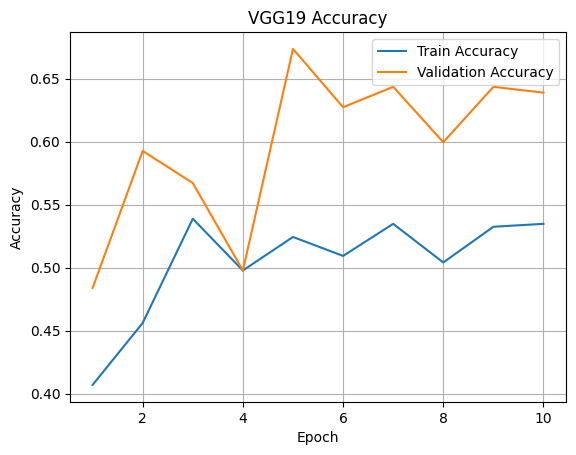

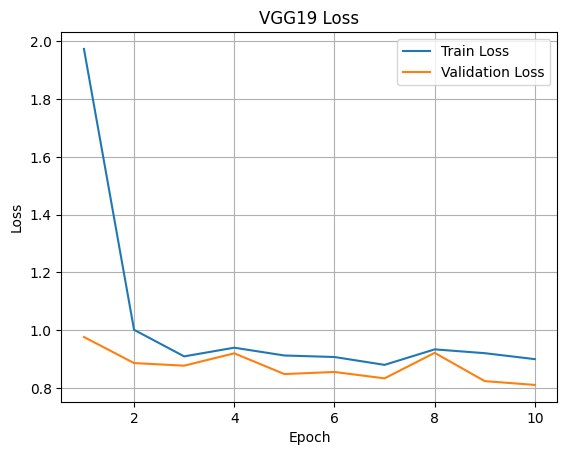

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

VGG19.eval()
all_preds = []
all_labels = []
correct = 0
total = 0

with torch.no_grad():
    for images, labels in bc_val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = VGG19(images)
        _, preds = torch.max(outputs, 1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

y_true = np.array(all_labels)
y_pred = np.array(all_preds)

sklearn_accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

vgg_metrics = {
    "accuracy": round(sklearn_accuracy, 4),
    "precision": round(precision, 4),
    "recall": round(recall, 4),
    "f1": round(f1, 4)
}
print("VGG19 Evaluation Metrics:")
for key, value in vgg_metrics.items():
    print(f"{key}: {value}")

# ACCURACY
plt.plot(range(1, num_epochs+1), vgg_train_accuracies, label="Train Accuracy")
plt.plot(range(1, num_epochs+1), vgg_val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("VGG19 Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# LOSS
plt.plot(range(1, num_epochs+1), vgg_train_losses, label="Train Loss")
plt.plot(range(1, num_epochs+1), vgg_val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("VGG19 Loss")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from torchvision.models import resnet50
resnet50 = resnet50()
num_features = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_features, 3) # 3 Classes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50 = resnet50.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.parameters(), lr=0.0001)

epochs = 10
rn_train_losses = []
rn_train_accuracies = []
rn_val_losses = []
rn_val_accuracies = []

for epoch in range(epochs):
    resnet50.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in bc_train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct/total
    rn_train_losses.append(epoch_loss)
    rn_train_accuracies.append(epoch_accuracy)

    resnet50.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in bc_val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = resnet50(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

        rn_val_losses.append(val_loss/len(val_loader))
        rn_val_accuracies.append(val_correct/val_total)

        print(f"Epoch {epoch+1}/10, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_accuracy:.4f}, Val Loss:{rn_val_losses[-1]:.4f}, Val Acc: {rn_val_accuracies[-1]:.4f}")

Epoch 1/10, Train Loss: 0.8872, Train Acc: 0.6638, Val Loss:1.0868, Val Acc: 0.4699
Epoch 2/10, Train Loss: 0.7181, Train Acc: 0.7309, Val Loss:1.0013, Val Acc: 0.6250
Epoch 3/10, Train Loss: 0.6728, Train Acc: 0.7483, Val Loss:0.9090, Val Acc: 0.6019
Epoch 4/10, Train Loss: 0.6209, Train Acc: 0.7818, Val Loss:0.9190, Val Acc: 0.5764
Epoch 5/10, Train Loss: 0.5853, Train Acc: 0.7905, Val Loss:1.2473, Val Acc: 0.5810
Epoch 6/10, Train Loss: 0.5316, Train Acc: 0.8189, Val Loss:0.8925, Val Acc: 0.6829
Epoch 7/10, Train Loss: 0.4776, Train Acc: 0.8478, Val Loss:1.4675, Val Acc: 0.4861
Epoch 8/10, Train Loss: 0.4186, Train Acc: 0.8640, Val Loss:0.7413, Val Acc: 0.8009
Epoch 9/10, Train Loss: 0.3388, Train Acc: 0.8877, Val Loss:0.8556, Val Acc: 0.8148
Epoch 10/10, Train Loss: 0.3081, Train Acc: 0.8987, Val Loss:0.5036, Val Acc: 0.8495


ResNet50 Evaluation metrics: 
accuracy:0.85
precision:0.8634
recall:0.8495
f1:0.8514


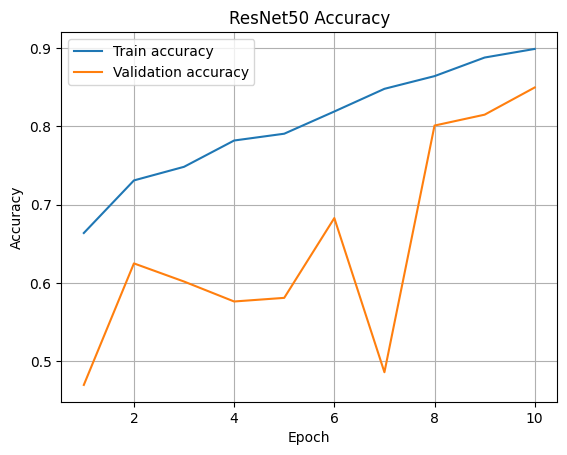

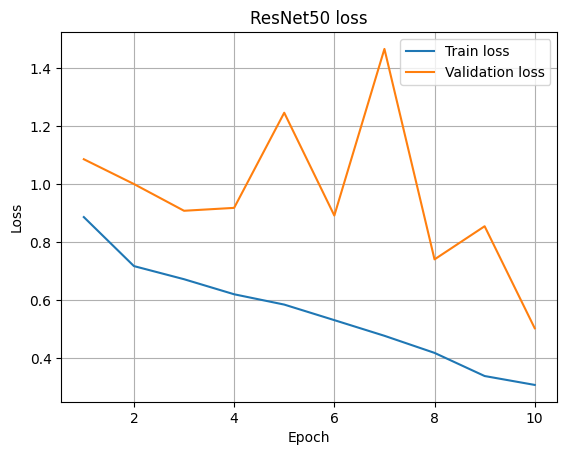

In [ ]:
epochs = 10

resnet50.eval()
all_preds = []
all_labels = []
correct = 0
total = 0

with torch.no_grad():
    for images, labels in bc_val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet50(images)
        _, preds = torch.max(outputs, 1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

y_true = np.array(all_labels)
y_pred = np.array(all_preds)

resnet_metrics = {
    "accuracy":round(correct / total, 2),
    "precision":round(precision_score(y_true, y_pred, average="weighted"), 4),
    "recall":round(recall_score(y_true, y_pred, average="weighted"),4),
    "f1":round(f1_score(y_true, y_pred, average="weighted"), 4)
}
print("ResNet50 Evaluation metrics: ")
for key, value in resnet_metrics.items():
    if key != "Model":
        print(f"{key}:{value}")

plt.plot(range(1, epochs+1), rn_train_accuracies, label="Train accuracy")
plt.plot(range(1, epochs+1), rn_val_accuracies, label="Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("ResNet50 Accuracy")
plt.legend()
plt.grid(True)
plt.show()

plt.plot(range(1, epochs+1), rn_train_losses, label="Train loss")
plt.plot(range(1, epochs+1), rn_val_losses, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("ResNet50 loss")
plt.legend()
plt.grid(True)
plt.show()

Found 1728 images belonging to 3 classes.
Found 432 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.4373 - loss: 1.1709
Epoch 1: val_accuracy improved from -inf to 0.64815, saving model to /content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/saved_models/best_mobilenetv2_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 433ms/step - accuracy: 0.4383 - loss: 1.1691 - val_accuracy: 0.6481 - val_loss: 0.8421
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.6257 - loss: 0.8693
Epoch 2: val_accuracy improved from 0.64815 to 0.74074, saving model to /content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/saved_models/best_mobilenetv2_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 348ms/step - accuracy: 0.6261 - loss: 0.8684 - val_accuracy: 0.7407 - val_loss: 0.6648
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.7137 - loss: 0.6818
Epoch 3: val_accuracy improved from 0.74074 to 0.77315, saving model to /content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/saved_models/best_mobilenetv2_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 304ms/step - accuracy: 0.7138 - loss: 0.6816 - val_accuracy: 0.7731 - val_loss: 0.5714
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.7453 - loss: 0.6256
Epoch 4: val_accuracy improved from 0.77315 to 0.79398, saving model to /content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/saved_models/best_mobilenetv2_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 299ms/step - accuracy: 0.7452 - loss: 0.6253 - val_accuracy: 0.7940 - val_loss: 0.5107
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.7832 - loss: 0.5435
Epoch 5: val_accuracy improved from 0.79398 to 0.80324, saving model to /content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/saved_models/best_mobilenetv2_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 300ms/step - accuracy: 0.7831 - loss: 0.5435 - val_accuracy: 0.8032 - val_loss: 0.4755
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.7800 - loss: 0.5029
Epoch 6: val_accuracy improved from 0.80324 to 0.80787, saving model to /content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/saved_models/best_mobilenetv2_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 334ms/step - accuracy: 0.7801 - loss: 0.5031 - val_accuracy: 0.8079 - val_loss: 0.4466
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.8173 - loss: 0.4626
Epoch 7: val_accuracy improved from 0.80787 to 0.82176, saving model to /content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/saved_models/best_mobilenetv2_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 294ms/step - accuracy: 0.8172 - loss: 0.4627 - val_accuracy: 0.8218 - val_loss: 0.4239
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.8205 - loss: 0.4448
Epoch 8: val_accuracy improved from 0.82176 to 0.83333, saving model to /content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/saved_models/best_mobilenetv2_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 293ms/step - accuracy: 0.8202 - loss: 0.4450 - val_accuracy: 0.8333 - val_loss: 0.4081
Epoch 9/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.8161 - loss: 0.4309
Epoch 9: val_accuracy did not improve from 0.83333
54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 278ms/step - accuracy: 0.8162 - loss: 0.4310 - val_accuracy: 0.8241 - val_loss: 0.3970
Epoch 10/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.8177 - loss: 0.4301
Epoch 10: val_accuracy did not improve from 0.83333
54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 276ms/step - accuracy: 0.8178 - loss: 0.4301 - val_accuracy: 0.8264 - val_loss: 0.3851
Epoch 11/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.8470 - loss: 0.3844
Epoch 11: val_accuracy improved from 0.83333 to 0.83565, saving model to /content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/saved_models/best_mobilenetv2_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 293ms/step - accuracy: 0.8468 - loss: 0.3847 - val_accuracy: 0.8356 - val_loss: 0.3709
Epoch 12/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.8275 - loss: 0.4030
Epoch 12: val_accuracy improved from 0.83565 to 0.84028, saving model to /content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/saved_models/best_mobilenetv2_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 21s 294ms/step - accuracy: 0.8279 - loss: 0.4027 - val_accuracy: 0.8403 - val_loss: 0.3639
Epoch 13/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.8423 - loss: 0.3945
Epoch 13: val_accuracy improved from 0.84028 to 0.85185, saving model to /content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/saved_models/best_mobilenetv2_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 290ms/step - accuracy: 0.8423 - loss: 0.3943 - val_accuracy: 0.8519 - val_loss: 0.3527
Epoch 14/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.8545 - loss: 0.3452
Epoch 14: val_accuracy did not improve from 0.85185
54/54 ━━━━━━━━━━━━━━━━━━━━ 22s 313ms/step - accuracy: 0.8545 - loss: 0.3454 - val_accuracy: 0.8426 - val_loss: 0.3471
Epoch 15/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.8665 - loss: 0.3380
Epoch 15: val_accuracy did not improve from 0.85185
54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 280ms/step - accuracy: 0.8665 - loss: 0.3381 - val_accuracy: 0.8495 - val_loss: 0.3402
Epoch 16/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.8614 - loss: 0.3434
Epoch 16: val_accuracy did not improve from 0.85185
54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 286ms/step - accuracy: 0.8614 - loss: 0.3434 - val_accuracy: 0.8472 - val_loss: 0.3350
Epoch 17/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.8597 - loss: 0.3525
Epoch 17: val_accuracy i

54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 300ms/step - accuracy: 0.8597 - loss: 0.3524 - val_accuracy: 0.8565 - val_loss: 0.3294
Epoch 18/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.8740 - loss: 0.3334
Epoch 18: val_accuracy improved from 0.85648 to 0.85880, saving model to /content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/saved_models/best_mobilenetv2_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 297ms/step - accuracy: 0.8739 - loss: 0.3335 - val_accuracy: 0.8588 - val_loss: 0.3246
Epoch 19/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.8782 - loss: 0.3292
Epoch 19: val_accuracy improved from 0.85880 to 0.86574, saving model to /content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/saved_models/best_mobilenetv2_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 294ms/step - accuracy: 0.8782 - loss: 0.3291 - val_accuracy: 0.8657 - val_loss: 0.3201
Epoch 20/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.8686 - loss: 0.3129
Epoch 20: val_accuracy did not improve from 0.86574
54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 278ms/step - accuracy: 0.8686 - loss: 0.3129 - val_accuracy: 0.8519 - val_loss: 0.3193
Epoch 21/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.8769 - loss: 0.3085
Epoch 21: val_accuracy did not improve from 0.86574
54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 272ms/step - accuracy: 0.8769 - loss: 0.3085 - val_accuracy: 0.8657 - val_loss: 0.3138
Epoch 22/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.8757 - loss: 0.2974
Epoch 22: val_accuracy improved from 0.86574 to 0.86806, saving model to /content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/saved_models/best_mobilenetv2_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 347ms/step - accuracy: 0.8757 - loss: 0.2976 - val_accuracy: 0.8681 - val_loss: 0.3092
Epoch 23/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.8791 - loss: 0.3094
Epoch 23: val_accuracy did not improve from 0.86806
54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 274ms/step - accuracy: 0.8791 - loss: 0.3093 - val_accuracy: 0.8634 - val_loss: 0.3068
Epoch 24/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.8917 - loss: 0.2753
Epoch 24: val_accuracy did not improve from 0.86806
54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 279ms/step - accuracy: 0.8916 - loss: 0.2755 - val_accuracy: 0.8634 - val_loss: 0.3078
Epoch 25/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.8836 - loss: 0.2939
Epoch 25: val_accuracy did not improve from 0.86806
54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 276ms/step - accuracy: 0.8838 - loss: 0.2937 - val_accuracy: 0.8681 - val_loss: 0.3005
Epoch 26/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.8953 - loss: 0.2665
Epoch 26: val_accuracy d

54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 341ms/step - accuracy: 0.8856 - loss: 0.2960 - val_accuracy: 0.8704 - val_loss: 0.2962
Epoch 28/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9031 - loss: 0.2596
Epoch 28: val_accuracy improved from 0.87037 to 0.87731, saving model to /content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/saved_models/best_mobilenetv2_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 305ms/step - accuracy: 0.9029 - loss: 0.2598 - val_accuracy: 0.8773 - val_loss: 0.2922
Epoch 29/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.8844 - loss: 0.2737
Epoch 29: val_accuracy improved from 0.87731 to 0.87963, saving model to /content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/saved_models/best_mobilenetv2_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 17s 308ms/step - accuracy: 0.8847 - loss: 0.2735 - val_accuracy: 0.8796 - val_loss: 0.2907
Epoch 30/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.8920 - loss: 0.2731
Epoch 30: val_accuracy did not improve from 0.87963
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 284ms/step - accuracy: 0.8920 - loss: 0.2730 - val_accuracy: 0.8727 - val_loss: 0.2883
Epoch 31/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.8999 - loss: 0.2704
Epoch 31: val_accuracy improved from 0.87963 to 0.88426, saving model to /content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/saved_models/best_mobilenetv2_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 17s 307ms/step - accuracy: 0.8998 - loss: 0.2703 - val_accuracy: 0.8843 - val_loss: 0.2847
Epoch 32/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.8954 - loss: 0.2620
Epoch 32: val_accuracy did not improve from 0.88426
54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 284ms/step - accuracy: 0.8954 - loss: 0.2620 - val_accuracy: 0.8819 - val_loss: 0.2833
Epoch 33/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.8956 - loss: 0.2548
Epoch 33: val_accuracy did not improve from 0.88426
54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 284ms/step - accuracy: 0.8957 - loss: 0.2548 - val_accuracy: 0.8796 - val_loss: 0.2808
Epoch 34/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9070 - loss: 0.2545
Epoch 34: val_accuracy did not improve from 0.88426
54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 280ms/step - accuracy: 0.9070 - loss: 0.2544 - val_accuracy: 0.8796 - val_loss: 0.2801
Epoch 35/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.8978 - loss: 0.2465
Epoch 35: val_accuracy d

54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 345ms/step - accuracy: 0.9071 - loss: 0.2381 - val_accuracy: 0.8866 - val_loss: 0.2682
Epoch 44/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.9043 - loss: 0.2438
Epoch 44: val_accuracy did not improve from 0.88657
54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 286ms/step - accuracy: 0.9045 - loss: 0.2434 - val_accuracy: 0.8773 - val_loss: 0.2693
Epoch 45/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.9280 - loss: 0.2246
Epoch 45: val_accuracy did not improve from 0.88657
54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 279ms/step - accuracy: 0.9279 - loss: 0.2246 - val_accuracy: 0.8819 - val_loss: 0.2675
Epoch 46/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.9229 - loss: 0.2101
Epoch 46: val_accuracy did not improve from 0.88657
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 329ms/step - accuracy: 0.9228 - loss: 0.2103 - val_accuracy: 0.8843 - val_loss: 0.2670
Epoch 47/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9203 - loss: 0.2248
Epoch 47: val_accuracy i

54/54 ━━━━━━━━━━━━━━━━━━━━ 17s 309ms/step - accuracy: 0.9203 - loss: 0.2246 - val_accuracy: 0.8889 - val_loss: 0.2635
Epoch 48/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9093 - loss: 0.2237
Epoch 48: val_accuracy did not improve from 0.88889
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 286ms/step - accuracy: 0.9094 - loss: 0.2237 - val_accuracy: 0.8843 - val_loss: 0.2619
Epoch 49/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9261 - loss: 0.2219
Epoch 49: val_accuracy did not improve from 0.88889
54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 284ms/step - accuracy: 0.9260 - loss: 0.2218 - val_accuracy: 0.8819 - val_loss: 0.2641
Epoch 50/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.9236 - loss: 0.2083
Epoch 50: val_accuracy improved from 0.88889 to 0.89120, saving model to /content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/saved_models/best_mobilenetv2_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 17s 307ms/step - accuracy: 0.9235 - loss: 0.2084 - val_accuracy: 0.8912 - val_loss: 0.2655
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 476ms/step
MobileNet v2 Evaluation metrics (from the best saved model): 
accuracy:0.8912
precision:0.8921
recall:0.8912
f1:0.8911


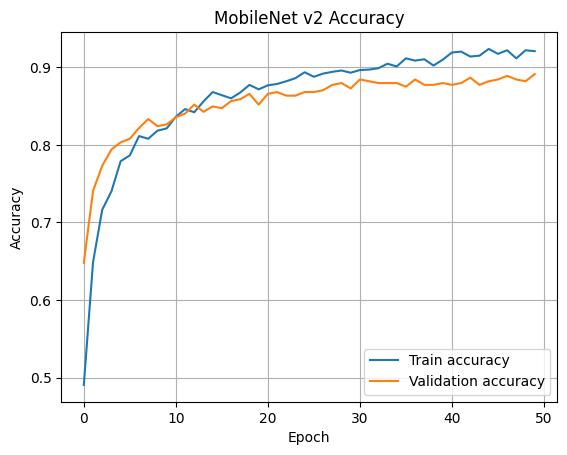

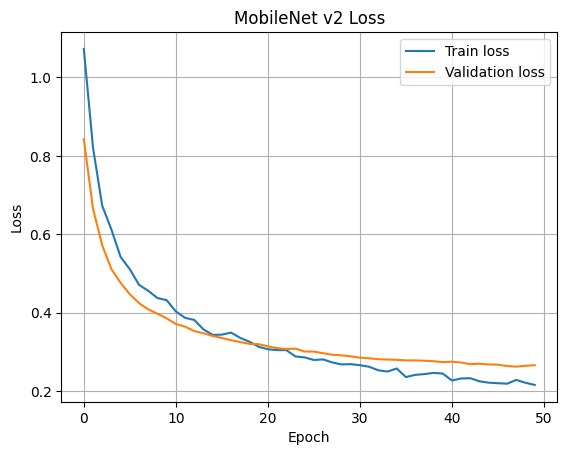

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define paths and parameters
data_dir = "/content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/datasets/preprocessed_data/bc_balanced_data"
img_size = (224, 224)
batch_size = 32
epochs = 50

# Data augmentation and splitting
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="training",
    shuffle=True
)
val_gen = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

# Build the MobileNetV2 model
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(3, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])

# Define the ModelCheckpoint callback
# This will save the best model weights based on validation accuracy
model_save_path = "/content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/saved_models/best_mobilenetv2_model.h5"
checkpoint_callback = ModelCheckpoint(
    filepath=model_save_path,
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

# Train the model with the callback
history = model.fit(
    train_generator,
    validation_data=val_gen,
    epochs=epochs,
    callbacks=[checkpoint_callback]  # Add the callback to the training process
)

# --- Model Evaluation (after training) ---

# Make predictions on the validation set
# We need to reload the best model weights to evaluate the best performing model,
# as the training history might not reflect the best model if it overfits later epochs.
best_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
best_model.trainable = False
x = best_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(3, activation="softmax")(x)
best_model = Model(inputs=best_model.input, outputs=output)
best_model.load_weights(model_save_path) # Load the best weights
best_model.compile(optimizer=Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])


# Reset the validation generator to ensure predictions are made from the beginning
val_gen.reset()
y_pred_probs = best_model.predict(val_gen)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = val_gen.classes

# Calculate evaluation metrics
mobilenet_metrics = {
    "accuracy": round(accuracy_score(y_true, y_pred), 4),
    "precision": round(precision_score(y_true, y_pred, average="weighted", zero_division=0), 4),
    "recall": round(recall_score(y_true, y_pred, average="weighted", zero_division=0), 4),
    "f1": round(f1_score(y_true, y_pred, average="weighted", zero_division=0), 4)
}

print("MobileNet v2 Evaluation metrics (from the best saved model): ")
for key, value in mobilenet_metrics.items():
    print(f"{key}:{value}")

# --- Plotting Training History ---

plt.plot(history.history["accuracy"], label="Train accuracy")
plt.plot(history.history["val_accuracy"], label="Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("MobileNet v2 Accuracy")
plt.legend()
plt.grid(True)
plt.show()

plt.plot(history.history["loss"], label="Train loss")
plt.plot(history.history["val_loss"], label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("MobileNet v2 Loss")
plt.legend()
plt.grid(True)
plt.show()

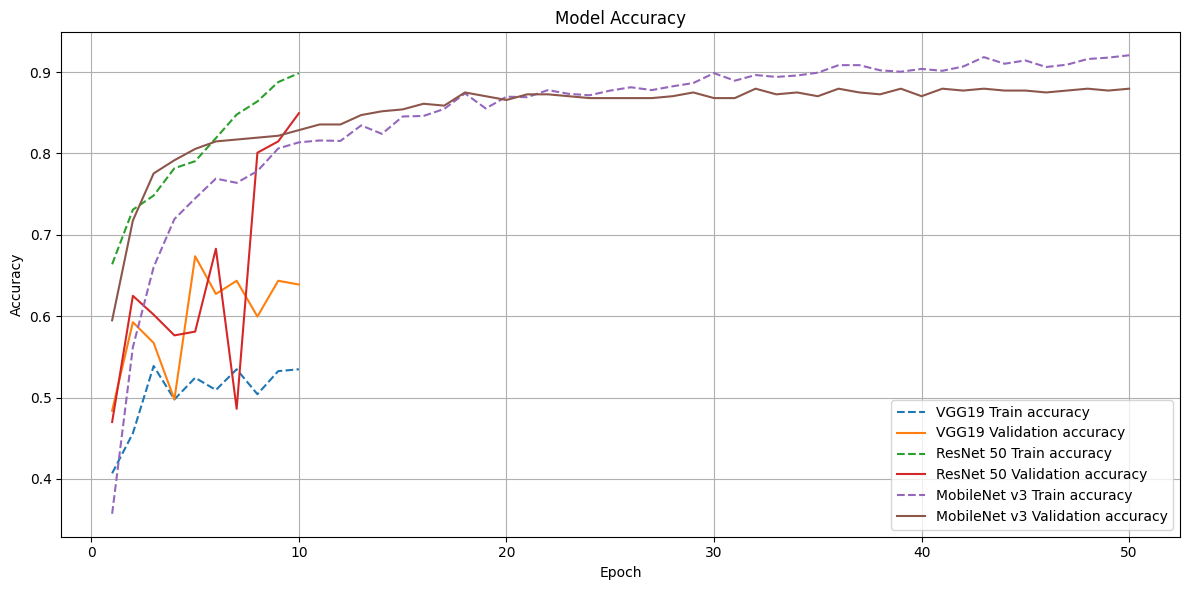

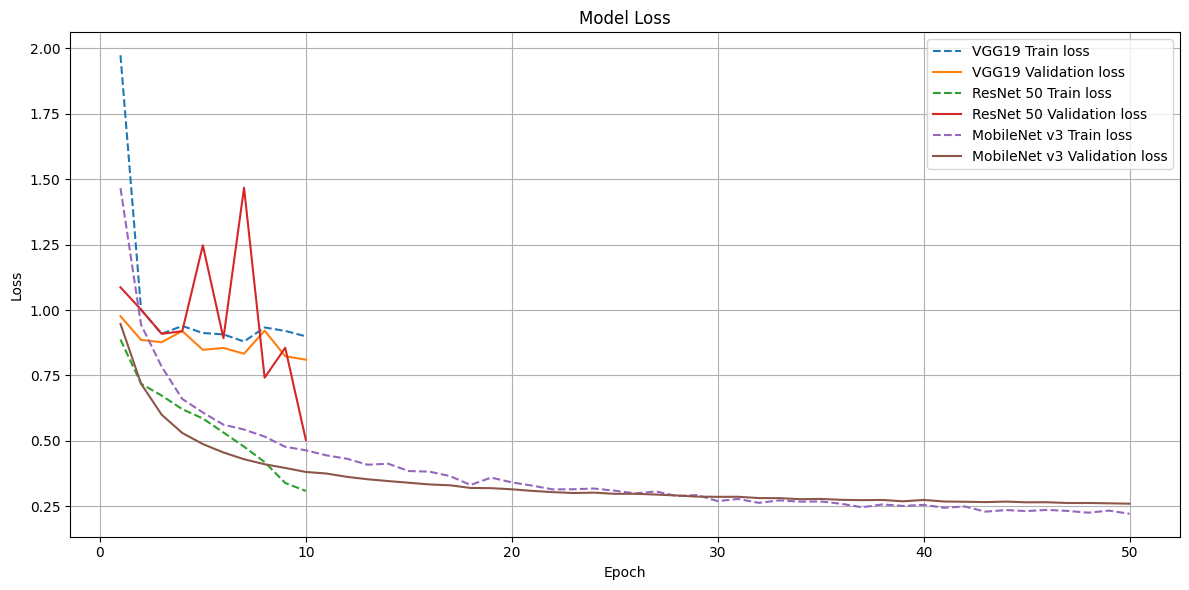

In [ ]:
# Epoch ranges for comparison of models
vgg_epochs = range(1,11)
resnet_epochs = range(1,11)
mobilenet_epochs = range(1, len(history.history["accuracy"])+1)

# ACCURACY
plt.figure(figsize=(12,6))
plt.plot(vgg_epochs, vgg_train_accuracies, "--", label="VGG19 Train accuracy")
plt.plot(vgg_epochs, vgg_val_accuracies, label="VGG19 Validation accuracy")
plt.plot(resnet_epochs, rn_train_accuracies, "--", label="ResNet 50 Train accuracy")
plt.plot(resnet_epochs, rn_val_accuracies, label="ResNet 50 Validation accuracy")
plt.plot(mobilenet_epochs, history.history["accuracy"], "--", label="MobileNet v3 Train accuracy")
plt.plot(mobilenet_epochs, history.history["val_accuracy"], label="MobileNet v3 Validation accuracy")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# LOSS
plt.figure(figsize=(12,6))
plt.plot(vgg_epochs, vgg_train_losses, "--", label="VGG19 Train loss")
plt.plot(vgg_epochs, vgg_val_losses, label="VGG19 Validation loss")
plt.plot(resnet_epochs, rn_train_losses, "--", label="ResNet 50 Train loss")
plt.plot(resnet_epochs, rn_val_losses, label="ResNet 50 Validation loss")
plt.plot(mobilenet_epochs, history.history["loss"], "--", label="MobileNet v3 Train loss")
plt.plot(mobilenet_epochs, history.history["val_loss"], label="MobileNet v3 Validation loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Model Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

              accuracy  precision  recall      f1
Model                                            
VGG19           0.6389     0.7743  0.6389  0.5815
ResNet50        0.8500     0.8634  0.8495  0.8514
MobileNet v3    0.8796     0.8800  0.8796  0.8798


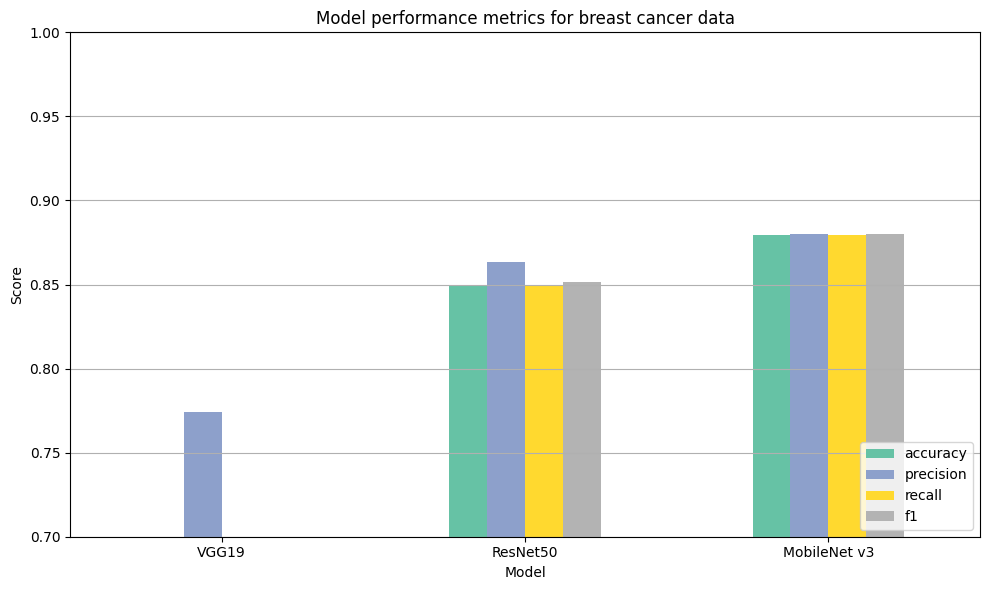

In [ ]:
import pandas as pd

all_metrics = [
    {"Model":"VGG19", **vgg_metrics},
    {"Model":"ResNet50", **resnet_metrics},
    {"Model":"MobileNet v3", **mobilenet_metrics}
]

df = pd.DataFrame(all_metrics)
df.set_index("Model", inplace=True)

print(df)

df.plot(kind="bar", figsize=(10,6), colormap="Set2")
plt.title("Model performance metrics for breast cancer data")
plt.ylabel("Score")
plt.ylim(0.7, 1.0)
plt.grid(True, axis="y")
plt.xticks(rotation=0)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# Brain Tumor

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
import cv2
from tqdm import tqdm
import itertools

# Renamed to avoid conflict with torchvision.models.resnet50
def load_data_helper(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
TRAIN_DIR_NO = '/content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/datasets/preprocessed_data/brain_tumor_split/TRAIN/NO/'
TRAIN_DIR_YES = '/content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/datasets/preprocessed_data/brain_tumor_split/TRAIN/YES/'
TEST_DIR_NO = '/content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/datasets/preprocessed_data/brain_tumor_split/TEST/NO/'
TEST_DIR_YES = '/content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/datasets/preprocessed_data/brain_tumor_split/TEST/YES/'
VAL_DIR_NO = '/content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/datasets/preprocessed_data/brain_tumor_split/VAL/NO/'
VAL_DIR_YES = '/content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/datasets/preprocessed_data/brain_tumor_split/VAL/YES/'
IMG_SIZE = (224,224)

# Function to load images from a directory and assign a specific label
def load_images_with_label(dir_path, label, img_size=(224, 224)):
    X = []
    y = []
    if os.path.exists(dir_path):
        print(f"Loading images from: {dir_path}")
        for file in tqdm(os.listdir(dir_path)):
            if not file.startswith('.'):
                img_path = os.path.join(dir_path, file)
                try:
                    img = cv2.imread(img_path)
                    if img is not None:
                        img = cv2.resize(img, img_size)
                        # Ensure the image has 3 channels (for color images)
                        if len(img.shape) == 2: # Convert grayscale to color
                            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
                        elif img.shape[2] == 4: # Convert RGBA to RGB
                            img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)
                        X.append(img)
                        y.append(label)
                    else:
                        print(f"Warning: Could not read image: {img_path}")
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")
    else:
        print(f"Directory not found: {dir_path}")
    return np.array(X), np.array(y)


# Load data for each class and split with explicit labels
X_train_no, y_train_no = load_images_with_label(TRAIN_DIR_NO, 0, IMG_SIZE) # 0 for NO
X_train_yes, y_train_yes = load_images_with_label(TRAIN_DIR_YES, 1, IMG_SIZE) # 1 for YES
X_test_no, y_test_no = load_images_with_label(TEST_DIR_NO, 0, IMG_SIZE)
X_test_yes, y_test_yes = load_images_with_label(TEST_DIR_YES, 1, IMG_SIZE)
X_val_no, y_val_no = load_images_with_label(VAL_DIR_NO, 0, IMG_SIZE)
X_val_yes, y_val_yes = load_images_with_label(VAL_DIR_YES, 1, IMG_SIZE)


# Concatenate data from both classes for each split
X_train = np.concatenate((X_train_no, X_train_yes), axis=0)
y_train = np.concatenate((y_train_no, y_train_yes), axis=0)
X_test = np.concatenate((X_test_no, X_test_yes), axis=0)
y_test = np.concatenate((y_test_no, y_test_yes), axis=0)
X_val = np.concatenate((X_val_no, X_val_yes), axis=0)
y_val = np.concatenate((y_val_no, y_val_yes), axis=0)

# Update labels dictionary (assuming 'NO' is class 0 and 'YES' is class 1)
labels = {0: 'NO', 1: 'YES'}

print("Data loading complete.")
print(f"Train data shape: {X_train.shape}, Train labels shape: {y_train.shape}")
print(f"Test data shape: {X_test.shape}, Test labels shape: {y_test.shape}")
print(f"Val data shape: {X_val.shape}, Val labels shape: {y_val.shape}")

Loading images from: /content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/datasets/preprocessed_data/brain_tumor_split/TRAIN/NO/


100%|██████████| 1436/1436 [00:42<00:00, 33.52it/s] 


Loading images from: /content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/datasets/preprocessed_data/brain_tumor_split/TRAIN/YES/


100%|██████████| 1445/1445 [00:40<00:00, 35.80it/s] 


Loading images from: /content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/datasets/preprocessed_data/brain_tumor_split/TEST/NO/


100%|██████████| 290/290 [00:06<00:00, 41.57it/s] 


Loading images from: /content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/datasets/preprocessed_data/brain_tumor_split/TEST/YES/


100%|██████████| 281/281 [00:06<00:00, 41.91it/s] 


Loading images from: /content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/datasets/preprocessed_data/brain_tumor_split/VAL/NO/


100%|██████████| 284/284 [00:06<00:00, 43.49it/s] 


Loading images from: /content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/datasets/preprocessed_data/brain_tumor_split/VAL/YES/


100%|██████████| 287/287 [00:06<00:00, 44.86it/s] 


Data loading complete.
Train data shape: (2881, 224, 224, 3), Train labels shape: (2881,)
Test data shape: (571, 224, 224, 3), Test labels shape: (571,)
Val data shape: (571, 224, 224, 3), Val labels shape: (571,)


In [ ]:
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
iplot(fig)

In [ ]:
# Define the same data transforms used for the previous data
data_transforms = transforms.Compose([
    transforms.ToPILImage(),  # Convert numpy array to PIL Image
    transforms.Resize((224, 224)), # VGG excepts 224x224 images
    transforms.ToTensor(), # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize with ImageNet stats
])

# Create custom Dataset classes or use TensorDataset for the numpy arrays
# Since we have features (X) and labels (y) separately as numpy arrays, TensorDataset is suitable

# Convert numpy arrays to torch tensors and apply transformations
X_train_tensor = torch.stack([data_transforms(img) for img in X_train])
y_train_tensor = torch.from_numpy(y_train).long() # Labels should be long type for CrossEntropyLoss

X_val_tensor = torch.stack([data_transforms(img) for img in X_val])
y_val_tensor = torch.from_numpy(y_val).long()

X_test_tensor = torch.stack([data_transforms(img) for img in X_test])
y_test_tensor = torch.from_numpy(y_test).long()

# Create TensorDatasets
train_dataset_bt = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
val_dataset_bt = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
test_dataset_bt = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)


# Create DataLoaders
batch_size = 32
train_loader_bt = DataLoader(train_dataset_bt, batch_size=batch_size, shuffle=True)
val_loader_bt = DataLoader(val_dataset_bt, batch_size=batch_size, shuffle=False)
test_loader_bt = DataLoader(test_dataset_bt, batch_size=batch_size, shuffle=False)

print("Brain Tumor Data Preprocessing Complete.")
print(f"Number of training samples: {len(train_dataset_bt)}")
print(f"Number of validation samples: {len(val_dataset_bt)}")
print(f"Number of test samples: {len(test_dataset_bt)}")

Brain Tumor Data Preprocessing Complete.
Number of training samples: 2881
Number of validation samples: 571
Number of test samples: 571


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_vgg19 = vgg19() # Load pre-trained VGG19 model
for param in model_vgg19.features.parameters():
    param.requires_grad = False # Freeze the feature extractor layers

model_vgg19.classifier[6] = nn.Linear(4096, 2) #2 Classes: Yes or No
model_vgg19 = model_vgg19.to(device) # Move model to device

In [ ]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss() # Loss function
optimizer = optim.Adam(model_vgg19.parameters(), lr=0.0001)

num_epochs = 10
vgg_train_losses = []
vgg_train_accuracies = []
vgg_val_losses = []
vgg_val_accuracies = []

for epoch in range(num_epochs):
    model_vgg19.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader_bt:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_vgg19(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        __, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader_bt)
    epoch_accuracy = correct / total
    vgg_train_losses.append(epoch_loss)
    vgg_train_accuracies.append(epoch_accuracy)

    model_vgg19.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader_bt:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model_vgg19(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            __, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
        vgg_val_losses.append(val_loss / len(val_loader_bt))
        vgg_val_accuracies.append(val_correct / val_total)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}, Val Loss: {vgg_val_losses[-1]:.4f}, Val Accuracy: {vgg_val_accuracies[-1]:.4f}")

VGG19 Evaluation Metrics for Brain Tumor Data:
accuracy: 0.8564
precision: 0.8586
recall: 0.8564
f1: 0.8562


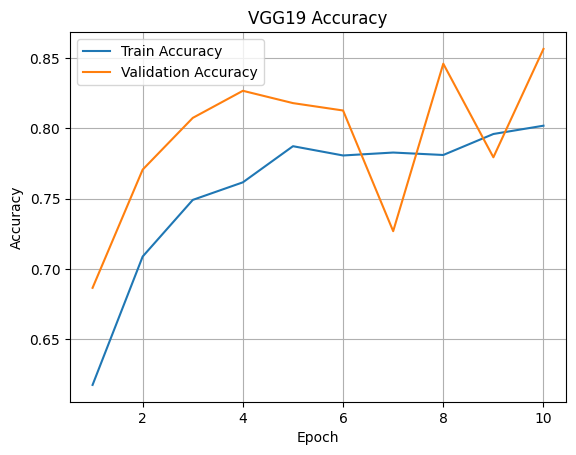

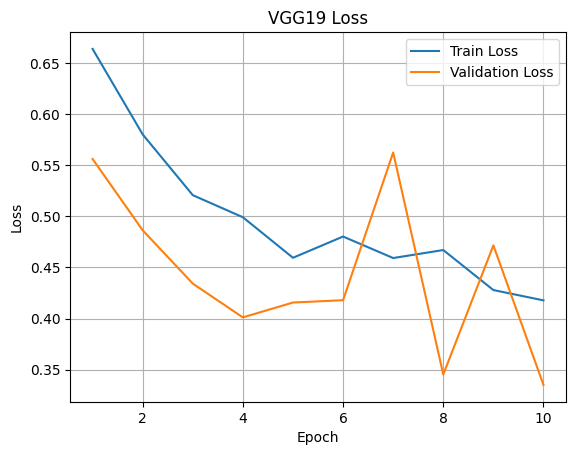

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

model_vgg19.eval()
all_preds = []
all_labels = []
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader_bt:
        images, labels = images.to(device), labels.to(device)
        outputs = model_vgg19(images)
        _, preds = torch.max(outputs, 1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

y_true = np.array(all_labels)
y_pred = np.array(all_preds)

sklearn_accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

vgg_metrics = {
    "accuracy": round(sklearn_accuracy, 4),
    "precision": round(precision, 4),
    "recall": round(recall, 4),
    "f1": round(f1, 4)
}
print("VGG19 Evaluation Metrics for Brain Tumor Data:")
for key, value in vgg_metrics.items():
    print(f"{key}: {value}")

# ACCURACY
plt.plot(range(1, num_epochs+1), vgg_train_accuracies, label="Train Accuracy")
plt.plot(range(1, num_epochs+1), vgg_val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("VGG19 Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# LOSS
plt.plot(range(1, num_epochs+1), vgg_train_losses, label="Train Loss")
plt.plot(range(1, num_epochs+1), vgg_val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("VGG19 Loss")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from torchvision.models import resnet50
resnet50 = resnet50()
num_features = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_features, 2) # 2 Classes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50 = resnet50.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.parameters(), lr=0.0001)

epochs = 10
rn_train_losses = []
rn_train_accuracies = []
rn_val_losses = []
rn_val_accuracies = []

# --- Additions for saving the best model ---
# Define the directory and filename for the saved model
save_dir = '/content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/saved_models'
os.makedirs(save_dir, exist_ok=True) # Create the directory if it doesn't exist
model_save_path = os.path.join(save_dir, 'best_resnet50_model.pth')

# Initialize the best validation loss to a very large number
best_val_loss = float('inf')
# --- End of additions ---

for epoch in range(epochs):
    resnet50.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader_bt:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader_bt)
    epoch_accuracy = correct/total
    rn_train_losses.append(epoch_loss)
    rn_train_accuracies.append(epoch_accuracy)

    resnet50.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader_bt:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = resnet50(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

        rn_val_losses.append(val_loss/len(val_loader_bt))
        rn_val_accuracies.append(val_correct/val_total)

        print(f"Epoch {epoch+1}/10, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_accuracy:.4f}, Val Loss:{rn_val_losses[-1]:.4f}, Val Acc: {rn_val_accuracies[-1]:.4f}")

    # --- Logic to save the best model ---
    if current_val_loss < best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {current_val_loss:.4f}. Saving model...")
        best_val_loss = current_val_loss
        # Save the model's state dictionary
        torch.save(resnet50.state_dict(), model_save_path)
    # --- End of logic ---

Epoch 1/10, Train Loss: 0.5482, Train Acc: 0.7279, Val Loss:0.4474, Val Acc: 0.7898
Validation loss improved from inf to 0.0514. Saving model...
Epoch 2/10, Train Loss: 0.4580, Train Acc: 0.7921, Val Loss:0.4884, Val Acc: 0.7776
Epoch 3/10, Train Loss: 0.3887, Train Acc: 0.8254, Val Loss:0.4493, Val Acc: 0.8039
Epoch 4/10, Train Loss: 0.3255, Train Acc: 0.8691, Val Loss:0.4847, Val Acc: 0.8109
Epoch 5/10, Train Loss: 0.2758, Train Acc: 0.8945, Val Loss:0.6784, Val Acc: 0.7863
Epoch 6/10, Train Loss: 0.2765, Train Acc: 0.8986, Val Loss:0.3278, Val Acc: 0.8459
Epoch 7/10, Train Loss: 0.1701, Train Acc: 0.9334, Val Loss:0.1027, Val Acc: 0.9562
Epoch 8/10, Train Loss: 0.1587, Train Acc: 0.9448, Val Loss:0.0880, Val Acc: 0.9755
Epoch 9/10, Train Loss: 0.1112, Train Acc: 0.9632, Val Loss:0.0551, Val Acc: 0.9790
Epoch 10/10, Train Loss: 0.1071, Train Acc: 0.9608, Val Loss:0.0574, Val Acc: 0.9807


ResNet50 Evaluation metrics for Brain Tumor Data: 
accuracy:0.98
precision:0.9759
recall:0.9755
f1:0.9755


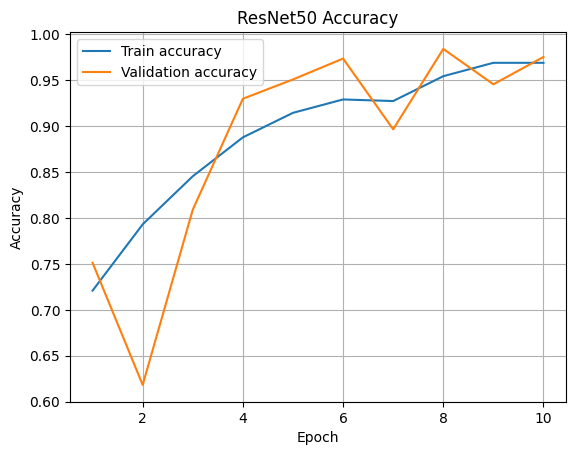

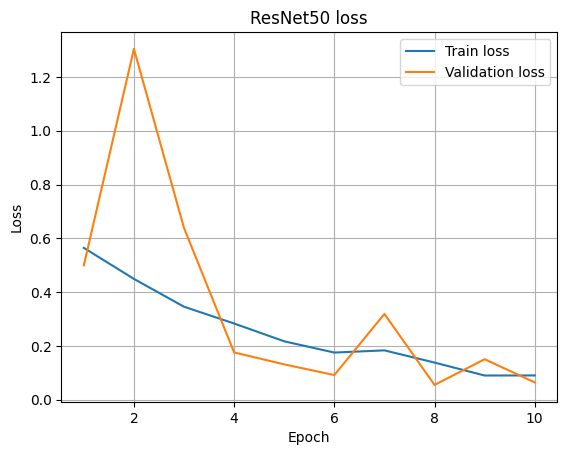

In [ ]:
epochs = 10

resnet50.eval()
all_preds = []
all_labels = []
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader_bt:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet50(images)
        _, preds = torch.max(outputs, 1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

y_true = np.array(all_labels)
y_pred = np.array(all_preds)

resnet_metrics = {
    "accuracy":round(correct / total, 2),
    "precision":round(precision_score(y_true, y_pred, average="weighted"), 4),
    "recall":round(recall_score(y_true, y_pred, average="weighted"),4),
    "f1":round(f1_score(y_true, y_pred, average="weighted"), 4)
}
print("ResNet50 Evaluation metrics for Brain Tumor Data: ")
for key, value in resnet_metrics.items():
    if key != "Model":
        print(f"{key}:{value}")

plt.plot(range(1, epochs+1), rn_train_accuracies, label="Train accuracy")
plt.plot(range(1, epochs+1), rn_val_accuracies, label="Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("ResNet50 Accuracy")
plt.legend()
plt.grid(True)
plt.show()

plt.plot(range(1, epochs+1), rn_train_losses, label="Train loss")
plt.plot(range(1, epochs+1), rn_val_losses, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("ResNet50 loss")
plt.legend()
plt.grid(True)
plt.show()

Converting PyTorch DataLoaders to NumPy arrays...


100%|██████████| 18/18 [00:00<00:00, 208.30it/s]


Conversion complete.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 27s 162ms/step - accuracy: 0.4791 - loss: 0.9895 - val_accuracy: 0.6270 - val_loss: 0.6558
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - accuracy: 0.5912 - loss: 0.7346 - val_accuracy: 0.7548 - val_loss: 0.5259
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.6887 - loss: 0.6073 - val_accuracy: 0.8249 - val_loss: 0.4445
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.7144 - loss: 0.5464 - val_accuracy: 0.8529 - val_loss: 0.3904
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.7495 - loss: 0.5010 - val_accuracy: 0.8757 - val_loss: 0.3563
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.7914 - loss: 0.4577 - val_accuracy: 0.8827 - val_loss: 0.3312
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.8190 - loss: 0.4085 - val_accuracy: 0.8914 - val_loss: 0.3130
Epoch 8/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 

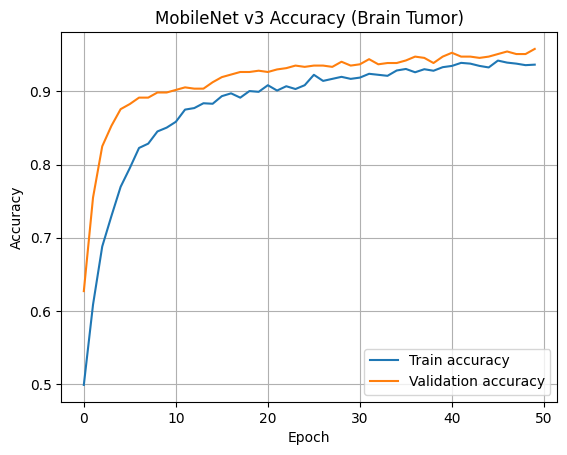

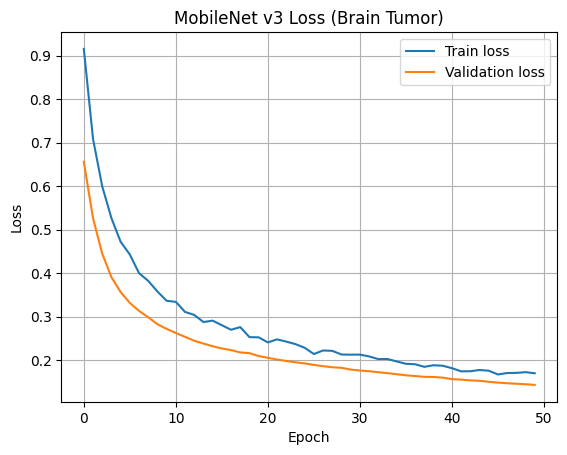

In [ ]:
img_size = (224, 224)
batch_size = 32
epochs = 50

# We already have train_loader_bt and val_loader_bt which are PyTorch DataLoaders
# MobileNetV2 from Keras expects data in a different format (NumPy arrays or TensorFlow Datasets)
# We will need to iterate through the PyTorch DataLoaders to get the data as NumPy arrays
# or create TensorFlow Datasets from the numpy arrays X_train, y_train, X_val, y_val

# Option 1: Convert PyTorch DataLoaders to NumPy arrays (can consume a lot of memory for large datasets)
# Function to convert PyTorch DataLoader to numpy arrays
def dataloader_to_numpy(dataloader):
    all_inputs = []
    all_labels = []
    for inputs, labels in tqdm(dataloader):
        all_inputs.append(inputs.permute(0, 2, 3, 1).cpu().numpy()) # Permute to (batch_size, height, width, channels)
        all_labels.append(labels.cpu().numpy())
    return np.concatenate(all_inputs), np.concatenate(all_labels)

print("Converting PyTorch DataLoaders to NumPy arrays...")
X_train_np, y_train_np = dataloader_to_numpy(train_loader_bt)
X_val_np, y_val_np = dataloader_to_numpy(val_loader_bt)
print("Conversion complete.")

# Ensure labels are one-hot encoded for categorical_crossentropy
y_train_encoded = tf.keras.utils.to_categorical(y_train_np, num_classes=2) # 2 classes: YES/NO
y_val_encoded = tf.keras.utils.to_categorical(y_val_np, num_classes=2)

# Option 2 (more memory efficient for very large datasets, not used here as Option 1 is sufficient):
# Create TensorFlow Datasets
# train_dataset_tf = tf.data.Dataset.from_tensor_slices((X_train_np, y_train_encoded)).batch(batch_size)
# val_dataset_tf = tf.data.Dataset.from_tensor_slices((X_val_np, y_val_encoded)).batch(batch_size)


base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(2, activation="softmax")(x) # 2 classes for brain tumor (YES/NO)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])

# Train the model using the NumPy arrays
# Using validation_split or validation_data with fit is possible with NumPy arrays
history = model.fit(X_train_np, y_train_encoded, validation_data=(X_val_np, y_val_encoded), epochs=epochs)

# Evaluate the model
y_pred_probs = model.predict(X_val_np)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = y_val_np # Use the original numeric labels for metrics

mobilenet_metrics_bt = {
    "accuracy":round(accuracy_score(y_true, y_pred), 4),
    "precision":round(precision_score(y_true, y_pred, average="weighted"),4),
    "recall":round(recall_score(y_true, y_pred, average="weighted"),4),
    "f1":round(f1_score(y_true, y_pred, average="weighted"),4)
}

print("MobileNet v2 Evaluation metrics for Brain Tumor Data: ")
for key, value in mobilenet_metrics_bt.items():
    print(f"{key}:{value}")

# Plot training history
plt.plot(history.history["accuracy"], label="Train accuracy")
plt.plot(history.history["val_accuracy"], label="Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("MobileNet v3 Accuracy (Brain Tumor)")
plt.legend()
plt.grid(True)
plt.show()

plt.plot(history.history["loss"], label="Train loss")
plt.plot(history.history["val_loss"], label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("MobileNet v3 Loss (Brain Tumor)")
plt.legend()
plt.grid(True)
plt.show()


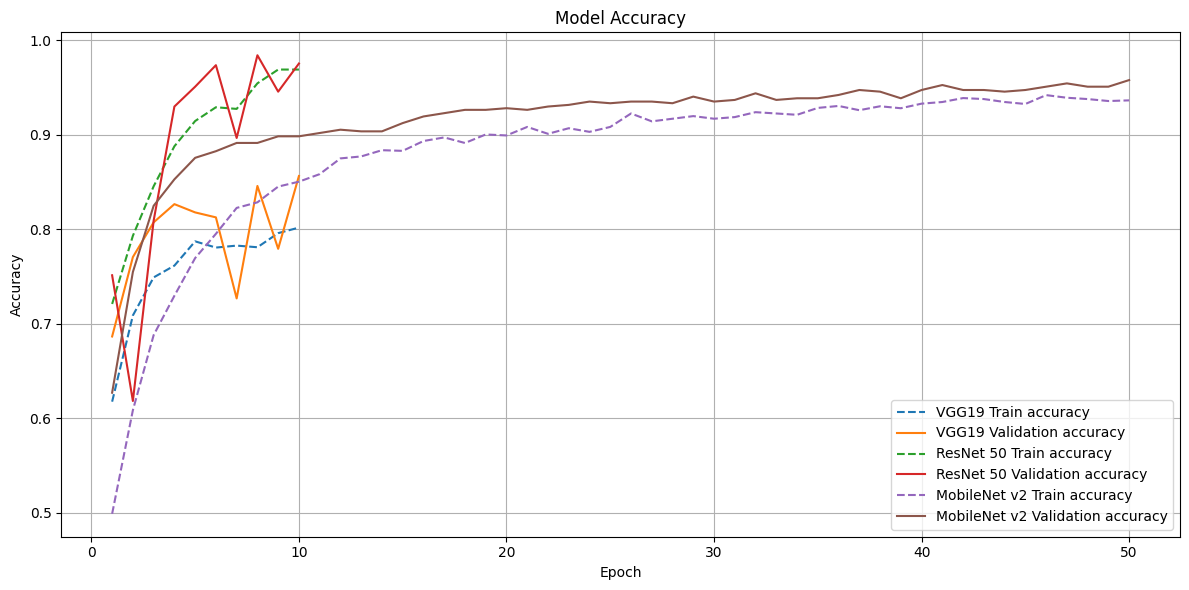

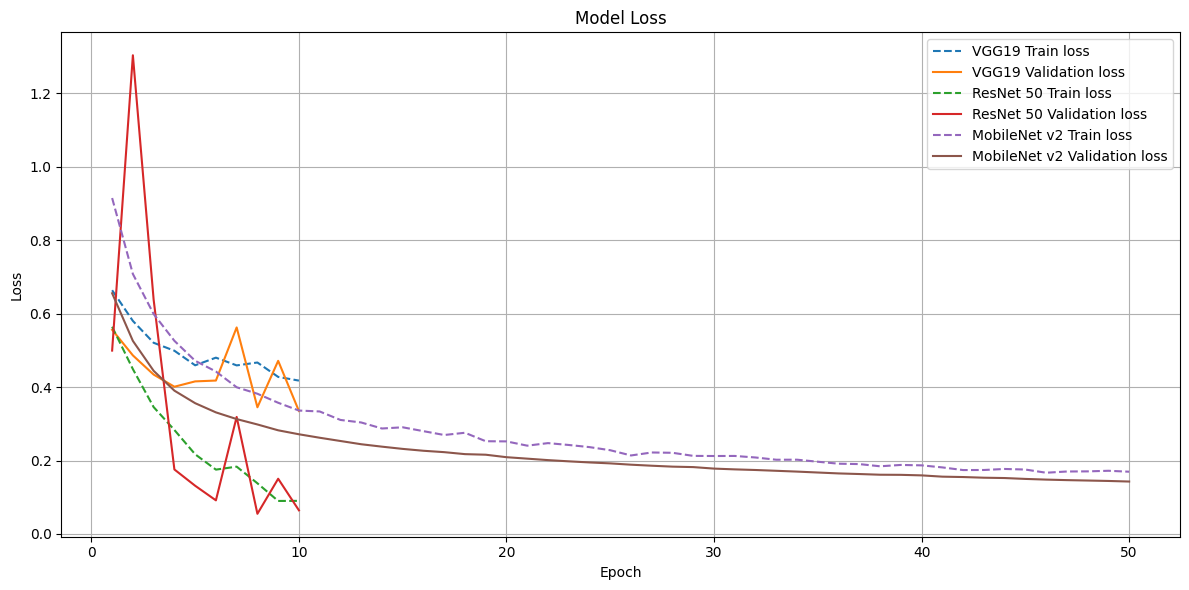

In [ ]:
# Epoch ranges for comparison of models
vgg_epochs = range(1,11)
resnet_epochs = range(1,11)
mobilenet_epochs = range(1, len(history.history["accuracy"])+1)

# ACCURACY
plt.figure(figsize=(12,6))
plt.plot(vgg_epochs, vgg_train_accuracies, "--", label="VGG19 Train accuracy")
plt.plot(vgg_epochs, vgg_val_accuracies, label="VGG19 Validation accuracy")
plt.plot(resnet_epochs, rn_train_accuracies, "--", label="ResNet 50 Train accuracy")
plt.plot(resnet_epochs, rn_val_accuracies, label="ResNet 50 Validation accuracy")
plt.plot(mobilenet_epochs, history.history["accuracy"], "--", label="MobileNet v2 Train accuracy")
plt.plot(mobilenet_epochs, history.history["val_accuracy"], label="MobileNet v2 Validation accuracy")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# LOSS
plt.figure(figsize=(12,6))
plt.plot(vgg_epochs, vgg_train_losses, "--", label="VGG19 Train loss")
plt.plot(vgg_epochs, vgg_val_losses, label="VGG19 Validation loss")
plt.plot(resnet_epochs, rn_train_losses, "--", label="ResNet 50 Train loss")
plt.plot(resnet_epochs, rn_val_losses, label="ResNet 50 Validation loss")
plt.plot(mobilenet_epochs, history.history["loss"], "--", label="MobileNet v2 Train loss")
plt.plot(mobilenet_epochs, history.history["val_loss"], label="MobileNet v2 Validation loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Model Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

              accuracy  precision  recall      f1
Model                                            
VGG19           0.8564     0.8586  0.8564  0.8562
ResNet50        0.9800     0.9759  0.9755  0.9755
MobileNet v3    0.9580     0.9583  0.9580  0.9580


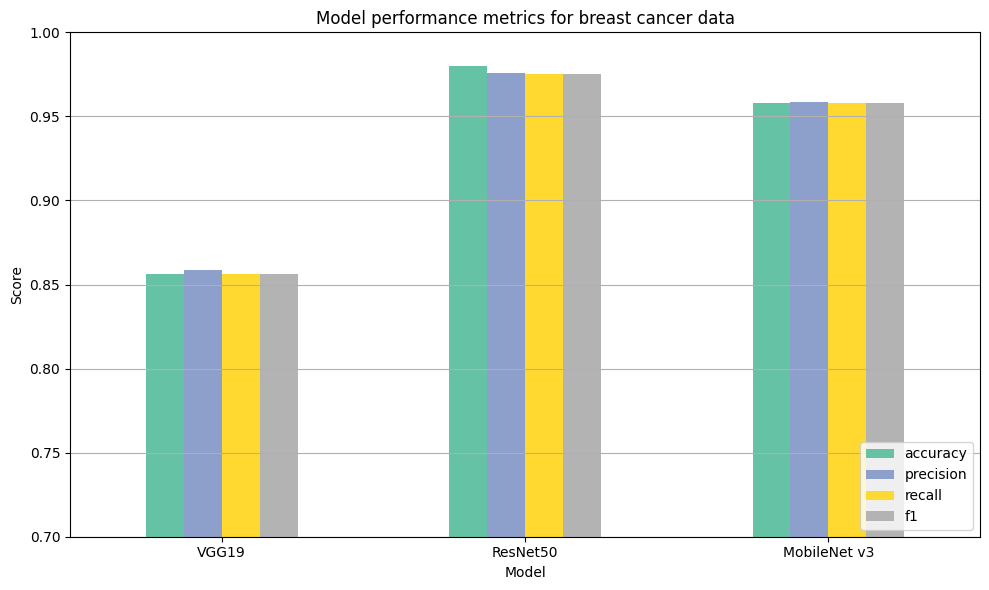

In [ ]:
import pandas as pd

all_metrics = [
    {"Model":"VGG19", **vgg_metrics},
    {"Model":"ResNet50", **resnet_metrics},
    {"Model":"MobileNet v3", **mobilenet_metrics_bt}
]

df = pd.DataFrame(all_metrics)
df.set_index("Model", inplace=True)

print(df)

df.plot(kind="bar", figsize=(10,6), colormap="Set2")
plt.title("Model performance metrics for breast cancer data")
plt.ylabel("Score")
plt.ylim(0.7, 1.0)
plt.grid(True, axis="y")
plt.xticks(rotation=0)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

For lung cancer the VGG19 model had the best performance, for the breast cancer data the MobileNet v2 model had the best performance and for the brain tumor data the resnet50 had the best performance. We now want to create a model that takes all this data into account and classify them correctly. This model could be an ensemble model of all 3 models we used VGG19, ResNet50 and MobileNet v2.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import datasets, models, transforms
import os
import copy

# --- Configuration ---
BREASTCANCER_DATA_DIR = '/content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/datasets/split_data/breast_cancer/'
LUNGCANCER_DATA_DIR = '/content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/datasets/split_data/lung_cancer/'
NUM_CLASSES = 3
NUM_EPOCHS = 10
BATCH_SIZE = 32
LEARNING_RATE = 0.001
MODEL_SAVE_PATH = '/content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/saved_models/best_resnet50_model_3_classes_combined.pth'

# --- Data Transformations ---
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# --- Load and Combine Datasets ---
# Load individual datasets
breast_cancer_datasets = {x: datasets.ImageFolder(os.path.join(BREASTCANCER_DATA_DIR, x), data_transforms[x]) for x in ['train', 'val']}
lung_cancer_datasets = {x: datasets.ImageFolder(os.path.join(LUNGCANCER_DATA_DIR, x), data_transforms[x]) for x in ['train', 'val']}

# Combine datasets
# Note: This assumes that the class-to-index mapping is consistent across datasets.
# For example, if 'class_A' is index 0 in the breast cancer dataset, any 'class_A'
# in the lung cancer dataset should also ideally be index 0. ImageFolder assigns
# indices based on alphabetical order of folder names.
image_datasets = {
    'train': ConcatDataset([breast_cancer_datasets['train'], lung_cancer_datasets['train']]),
    'val': ConcatDataset([breast_cancer_datasets['val'], lung_cancer_datasets['val']])
}

# --- Create DataLoaders ---
dataloaders = {x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

# It's good practice to ensure class names are what you expect.
# We'll take the class names from one of the original datasets,
# assuming the class structure is identical.
class_names = breast_cancer_datasets['train'].classes
print(f"Using data from: {BREASTCANCER_DATA_DIR} and {LUNGCANCER_DATA_DIR}")
print(f"Detected classes: {class_names}")
print(f"Training set size: {dataset_sizes['train']} images")
print(f"Validation set size: {dataset_sizes['val']} images")


# --- Initialize Model ---
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = models.resnet50(weights='IMAGENET1K_V1')  # Use pretrained weights
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, NUM_CLASSES)
model = model.to(device)

# --- Define Loss and Optimizer ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# --- Training Loop ---
best_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 10)

    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # deep copy the model
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), MODEL_SAVE_PATH)
            print(f"Saved best model to {MODEL_SAVE_PATH} with accuracy: {best_acc:.4f}")


print("Training complete.")
print(f'Best val Acc: {best_acc:4f}')

# load best model weights
model.load_state_dict(best_model_wts)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Using data from: /content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/datasets/split_data/breast_cancer/ and /content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/datasets/split_data/lung_cancer/
Detected classes: ['benign', 'malignant', 'normal']
Training set size: 3168 images
Validation set size: 396 images


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 92.1MB/s]


Epoch 1/10
----------
train Loss: 0.8949 Acc: 0.5650
val Loss: 0.8522 Acc: 0.5253
Saved best model to /content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/saved_models/best_resnet50_model_3_classes_combined.pth with accuracy: 0.5253
Epoch 2/10
----------
train Loss: 0.7849 Acc: 0.6054
val Loss: 4.1949 Acc: 0.4646
Epoch 3/10
----------
train Loss: 0.7601 Acc: 0.6187
val Loss: 0.9194 Acc: 0.5126
Epoch 4/10
----------
train Loss: 0.7199 Acc: 0.6307
val Loss: 0.7047 Acc: 0.7197
Saved best model to /content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/saved_models/best_resnet50_model_3_classes_combined.pth with accuracy: 0.7197
Epoch 5/10
----------
train Loss: 0.7207 Acc: 0.6373
val Loss: 0.6401 Acc: 0.6768
Epoch 6/10
----------
train Loss: 0.6980 Acc: 0.6600
val Loss: 0.7155 Acc: 0.6263
Epoch 7/10
----------
train Loss: 0.6841 Acc: 0.6619
val Loss: 5.5759 Acc: 0.5202
Epoch 8/10
----------
train Loss: 0.7067 Acc: 0.6635
val Loss: 0.6486 Acc: 0.6894
Epoch 9/10
-

<All keys matched successfully>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import datasets, models, transforms
import os
import copy

# --- Configuration ---
BREASTCANCER_DATA_DIR = '/content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/datasets/split_data/breast_cancer/'
LUNGCANCER_DATA_DIR = '/content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/datasets/split_data/lung_cancer/'
NUM_CLASSES = 3
NUM_EPOCHS = 10
BATCH_SIZE = 32
LEARNING_RATE = 0.001
# Changed the model save path to reflect the new architecture
MODEL_SAVE_PATH = '/content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/saved_models/best_vgg19_model_3_classes_combined.pth'

# --- Data Transformations ---
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# --- Load and Combine Datasets ---
# Load individual datasets
breast_cancer_datasets = {x: datasets.ImageFolder(os.path.join(BREASTCANCER_DATA_DIR, x), data_transforms[x]) for x in ['train', 'val']}
lung_cancer_datasets = {x: datasets.ImageFolder(os.path.join(LUNGCANCER_DATA_DIR, x), data_transforms[x]) for x in ['train', 'val']}

# Combine datasets
# Note: This assumes that the class-to-index mapping is consistent across datasets.
# For example, if 'class_A' is index 0 in the breast cancer dataset, any 'class_A'
# in the lung cancer dataset should also ideally be index 0. ImageFolder assigns
# indices based on alphabetical order of folder names.
image_datasets = {
    'train': ConcatDataset([breast_cancer_datasets['train'], lung_cancer_datasets['train']]),
    'val': ConcatDataset([breast_cancer_datasets['val'], lung_cancer_datasets['val']])
}

# --- Create DataLoaders ---
# Adjusted num_workers to 2 for common compatibility, can be set higher if resources allow
dataloaders = {x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=2) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

# It's good practice to ensure class names are what you expect.
# We'll take the class names from one of the original datasets,
# assuming the class structure is identical.
class_names = breast_cancer_datasets['train'].classes
print(f"Using data from: {BREASTCANCER_DATA_DIR} and {LUNGCANCER_DATA_DIR}")
print(f"Detected classes: {class_names}")
print(f"Training set size: {dataset_sizes['train']} images")
print(f"Validation set size: {dataset_sizes['val']} images")


# --- Initialize Model ---
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# [MODIFIED] Load the pretrained VGG19 model
model = models.vgg19(weights='IMAGENET1K_V1')

# [MODIFIED] The classifier in VGG is a Sequential module. We replace the last layer.
# VGG19's classifier has 6 layers (0-5) and a final output layer at index 6.
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, NUM_CLASSES)

model = model.to(device)

# --- Define Loss and Optimizer ---
criterion = nn.CrossEntropyLoss()
# Ensure optimizer is created after model parameters are finalized
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# --- Training Loop ---
best_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 10)

    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # deep copy the model
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), MODEL_SAVE_PATH)
            print(f"Saved best model to {MODEL_SAVE_PATH} with accuracy: {best_acc:.4f}")


print("Training complete.")
print(f'Best val Acc: {best_acc:4f}')

# load best model weights
model.load_state_dict(best_model_wts)

Using data from: /content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/datasets/split_data/breast_cancer/ and /content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/datasets/split_data/lung_cancer/
Detected classes: ['benign', 'malignant', 'normal']
Training set size: 3168 images
Validation set size: 396 images


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 147MB/s]


Epoch 1/10
----------
train Loss: 1.2854 Acc: 0.3759
val Loss: 1.0920 Acc: 0.3939
Saved best model to /content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/saved_models/best_vgg19_model_3_classes_combined.pth with accuracy: 0.3939
Epoch 2/10
----------
train Loss: 1.0899 Acc: 0.3744
val Loss: 1.1063 Acc: 0.3232
Epoch 3/10
----------
train Loss: 1.0951 Acc: 0.3819
val Loss: 1.0917 Acc: 0.3939
Epoch 4/10
----------
train Loss: 1.0935 Acc: 0.3886
val Loss: 1.1033 Acc: 0.3939
Epoch 5/10
----------
train Loss: 1.0970 Acc: 0.3741
val Loss: 1.0923 Acc: 0.3939
Epoch 6/10
----------
train Loss: 1.0962 Acc: 0.3854
val Loss: 1.0943 Acc: 0.3939
Epoch 7/10
----------
train Loss: 1.0960 Acc: 0.3867
val Loss: 1.0916 Acc: 0.3939
Epoch 8/10
----------
train Loss: 1.0938 Acc: 0.3873
val Loss: 1.0919 Acc: 0.3939
Epoch 9/10
----------
train Loss: 1.0945 Acc: 0.3895
val Loss: 1.0932 Acc: 0.3939
Epoch 10/10
----------
train Loss: 1.0946 Acc: 0.3902
val Loss: 1.0914 Acc: 0.3939
Training complet

<All keys matched successfully>